## Classifying Good Product Reviews: Deep Learning Model

**Team J Cubed**: James Wei, Jessica Ko, Jay Patel

CS 294-129, Fall 2016

**NOTE:** Most of the code for data handling, featurization, and model construction lies outside of this notebook. Please see the Python scripts in {src_root}/lib for exact implementation details.

### Organize imports

In [1]:
from __future__ import division, print_function, absolute_import
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2

### Set network parameters

In [2]:
# Dataset/Featurization Config
path = 'data/full_cols_good.csv'
label = 'good'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = 'genesisgood_run1'
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [3]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [4]:
%%time
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

CPU times: user 17.3 s, sys: 40 ms, total: 17.4 s
Wall time: 17.5 s


### Configure dataset

In [5]:
%%time
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/full_cols_good.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 200000
Tuning tf-idf classifier.


/u/44/prollm1/unix/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.
CPU times: user 5h 23min 33s, sys: 15min 3s, total: 5h 38min 37s
Wall time: 1h 5min 15s


### Prepare model configurations

In [6]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [7]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [8]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [9]:
# Run forward pass
logits = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/44/prollm1/unix/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [10]:
# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Train model

In [11]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.588354, Training Accuracy= 0.66667
Iter 300, Minibatch Loss= 0.723422, Training Accuracy= 0.40000
Iter 450, Minibatch Loss= 0.650391, Training Accuracy= 0.46667
Iter 600, Minibatch Loss= 0.665786, Training Accuracy= 0.53333
Iter 750, Minibatch Loss= 0.602901, Training Accuracy= 0.66667
Validation Accuracy: 0.55996
Validation Loss: 0.677242


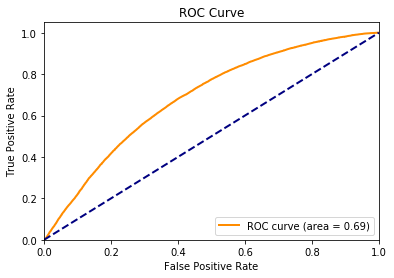

Iter 900, Minibatch Loss= 0.728585, Training Accuracy= 0.66667
Iter 1050, Minibatch Loss= 0.681602, Training Accuracy= 0.53333
Iter 1200, Minibatch Loss= 0.658081, Training Accuracy= 0.66667
Iter 1350, Minibatch Loss= 0.655997, Training Accuracy= 0.73333
Iter 1500, Minibatch Loss= 0.630890, Training Accuracy= 0.60000
Validation Accuracy: 0.64046
Validation Loss: 0.657058


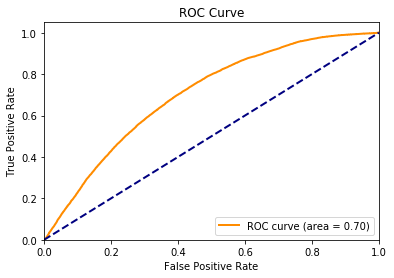

Iter 1650, Minibatch Loss= 0.677975, Training Accuracy= 0.40000
Iter 1800, Minibatch Loss= 0.695198, Training Accuracy= 0.53333
Iter 1950, Minibatch Loss= 0.658248, Training Accuracy= 0.66667
Iter 2100, Minibatch Loss= 0.602377, Training Accuracy= 0.66667
Iter 2250, Minibatch Loss= 0.687065, Training Accuracy= 0.46667
Validation Accuracy: 0.62876
Validation Loss: 0.667883
Iter 2400, Minibatch Loss= 0.659205, Training Accuracy= 0.66667
Iter 2550, Minibatch Loss= 0.588891, Training Accuracy= 0.66667
Iter 2700, Minibatch Loss= 0.591552, Training Accuracy= 0.53333
Iter 2850, Minibatch Loss= 0.713686, Training Accuracy= 0.60000
Iter 3000, Minibatch Loss= 0.613231, Training Accuracy= 0.66667
Validation Accuracy: 0.6503
Validation Loss: 0.634229


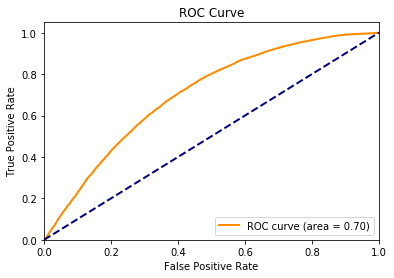

Iter 3150, Minibatch Loss= 0.556204, Training Accuracy= 0.80000
Iter 3300, Minibatch Loss= 0.874498, Training Accuracy= 0.60000
Iter 3450, Minibatch Loss= 0.682699, Training Accuracy= 0.66667
Iter 3600, Minibatch Loss= 0.582448, Training Accuracy= 0.80000
Iter 3750, Minibatch Loss= 0.559920, Training Accuracy= 0.80000
Validation Accuracy: 0.65312
Validation Loss: 0.639219


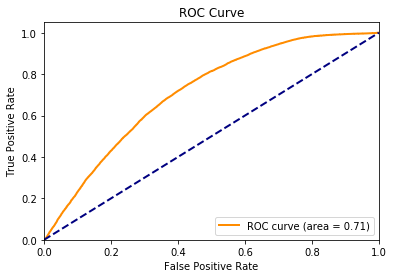

Iter 3900, Minibatch Loss= 0.458542, Training Accuracy= 0.73333
Iter 4050, Minibatch Loss= 0.654427, Training Accuracy= 0.60000
Iter 4200, Minibatch Loss= 0.693741, Training Accuracy= 0.33333
Iter 4350, Minibatch Loss= 0.728169, Training Accuracy= 0.60000
Iter 4500, Minibatch Loss= 0.596318, Training Accuracy= 0.73333
Validation Accuracy: 0.63288
Validation Loss: 0.636239
Iter 4650, Minibatch Loss= 0.603468, Training Accuracy= 0.60000
Iter 4800, Minibatch Loss= 0.541579, Training Accuracy= 0.73333
Iter 4950, Minibatch Loss= 0.631932, Training Accuracy= 0.53333
Iter 5100, Minibatch Loss= 0.602064, Training Accuracy= 0.73333
Iter 5250, Minibatch Loss= 0.605973, Training Accuracy= 0.73333
Validation Accuracy: 0.63772
Validation Loss: 0.634252
Iter 5400, Minibatch Loss= 0.730166, Training Accuracy= 0.53333
Iter 5550, Minibatch Loss= 0.624838, Training Accuracy= 0.66667
Iter 5700, Minibatch Loss= 0.694395, Training Accuracy= 0.53333
Iter 5850, Minibatch Loss= 0.781882, Training Accuracy= 0.

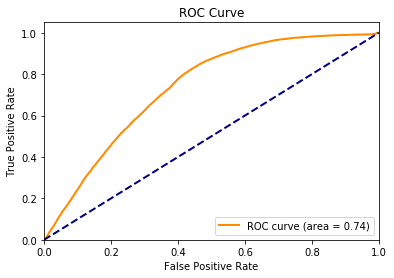

Iter 7650, Minibatch Loss= 0.748656, Training Accuracy= 0.46667
Iter 7800, Minibatch Loss= 0.511208, Training Accuracy= 0.80000
Iter 7950, Minibatch Loss= 0.556537, Training Accuracy= 0.73333
Iter 8100, Minibatch Loss= 0.377666, Training Accuracy= 0.86667
Iter 8250, Minibatch Loss= 0.376324, Training Accuracy= 0.80000
Validation Accuracy: 0.65104
Validation Loss: 0.700091
Iter 8400, Minibatch Loss= 0.568966, Training Accuracy= 0.66667
Iter 8550, Minibatch Loss= 0.613088, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.568349, Training Accuracy= 0.73333
Iter 8850, Minibatch Loss= 0.537257, Training Accuracy= 0.86667
Iter 9000, Minibatch Loss= 0.692982, Training Accuracy= 0.46667
Validation Accuracy: 0.62264
Validation Loss: 0.642072
Iter 9150, Minibatch Loss= 0.695555, Training Accuracy= 0.53333
Iter 9300, Minibatch Loss= 0.730857, Training Accuracy= 0.53333
Iter 9450, Minibatch Loss= 0.618860, Training Accuracy= 0.60000
Iter 9600, Minibatch Loss= 0.521211, Training Accuracy= 0.

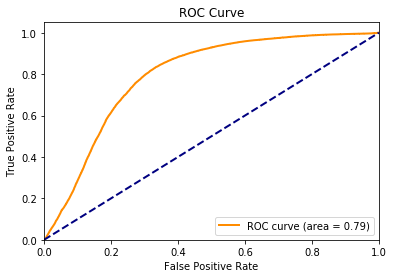

Iter 10650, Minibatch Loss= 0.616966, Training Accuracy= 0.73333
Iter 10800, Minibatch Loss= 0.629144, Training Accuracy= 0.80000
Iter 10950, Minibatch Loss= 0.522209, Training Accuracy= 0.80000
Iter 11100, Minibatch Loss= 0.631929, Training Accuracy= 0.53333
Iter 11250, Minibatch Loss= 0.714359, Training Accuracy= 0.53333
Validation Accuracy: 0.6707
Validation Loss: 0.612545
Iter 11400, Minibatch Loss= 0.671141, Training Accuracy= 0.46667
Iter 11550, Minibatch Loss= 0.435126, Training Accuracy= 0.80000
Iter 11700, Minibatch Loss= 0.588191, Training Accuracy= 0.73333
Iter 11850, Minibatch Loss= 0.680479, Training Accuracy= 0.73333
Iter 12000, Minibatch Loss= 0.578782, Training Accuracy= 0.60000
Validation Accuracy: 0.68654
Validation Loss: 0.601048
Iter 12150, Minibatch Loss= 0.482694, Training Accuracy= 0.80000
Iter 12300, Minibatch Loss= 0.558993, Training Accuracy= 0.73333
Iter 12450, Minibatch Loss= 0.579959, Training Accuracy= 0.73333
Iter 12600, Minibatch Loss= 0.558999, Training

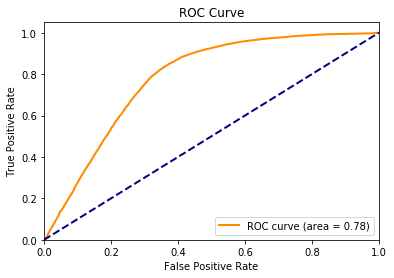

Iter 12900, Minibatch Loss= 0.538732, Training Accuracy= 0.86667
Iter 13050, Minibatch Loss= 0.556421, Training Accuracy= 0.73333
Iter 13200, Minibatch Loss= 0.679248, Training Accuracy= 0.60000
Iter 13350, Minibatch Loss= 0.809655, Training Accuracy= 0.53333
Iter 13500, Minibatch Loss= 0.614003, Training Accuracy= 0.66667
Validation Accuracy: 0.73234
Validation Loss: 0.578897
Iter 13650, Minibatch Loss= 0.518005, Training Accuracy= 0.86667
Iter 13800, Minibatch Loss= 0.527030, Training Accuracy= 0.60000
Iter 13950, Minibatch Loss= 0.395511, Training Accuracy= 0.86667
Iter 14100, Minibatch Loss= 0.690234, Training Accuracy= 0.60000
Iter 14250, Minibatch Loss= 0.670701, Training Accuracy= 0.66667
Validation Accuracy: 0.71294
Validation Loss: 0.577333
Iter 14400, Minibatch Loss= 1.218607, Training Accuracy= 0.66667
Iter 14550, Minibatch Loss= 0.525859, Training Accuracy= 0.66667
Iter 14700, Minibatch Loss= 0.543180, Training Accuracy= 0.66667
Iter 14850, Minibatch Loss= 0.340824, Trainin

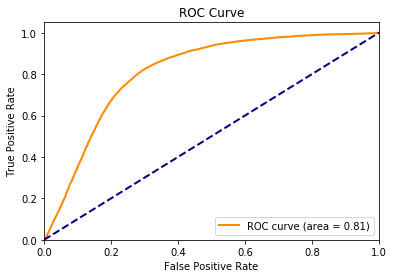

Iter 15150, Minibatch Loss= 0.707415, Training Accuracy= 0.53333
Iter 15300, Minibatch Loss= 0.381712, Training Accuracy= 0.93333
Iter 15450, Minibatch Loss= 0.669398, Training Accuracy= 0.60000
Iter 15600, Minibatch Loss= 0.383300, Training Accuracy= 0.93333
Iter 15750, Minibatch Loss= 0.713820, Training Accuracy= 0.80000
Validation Accuracy: 0.75524
Validation Loss: 0.562685
Iter 15900, Minibatch Loss= 0.671853, Training Accuracy= 0.60000
Iter 16050, Minibatch Loss= 0.572875, Training Accuracy= 0.73333
Iter 16200, Minibatch Loss= 0.440705, Training Accuracy= 0.86667
Iter 16350, Minibatch Loss= 0.594823, Training Accuracy= 0.60000
Iter 16500, Minibatch Loss= 0.576090, Training Accuracy= 0.73333
Validation Accuracy: 0.67508
Validation Loss: 0.615426
Iter 16650, Minibatch Loss= 0.383351, Training Accuracy= 0.86667
Iter 16800, Minibatch Loss= 0.512106, Training Accuracy= 0.80000
Iter 16950, Minibatch Loss= 0.583273, Training Accuracy= 0.73333
Iter 17100, Minibatch Loss= 0.547880, Trainin

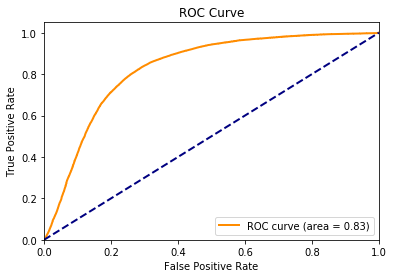

Iter 21150, Minibatch Loss= 0.485444, Training Accuracy= 0.80000
Iter 21300, Minibatch Loss= 0.586290, Training Accuracy= 0.66667
Iter 21450, Minibatch Loss= 0.501765, Training Accuracy= 0.73333
Iter 21600, Minibatch Loss= 0.338097, Training Accuracy= 0.80000
Iter 21750, Minibatch Loss= 0.378438, Training Accuracy= 0.93333
Validation Accuracy: 0.7373
Validation Loss: 0.559247
Iter 21900, Minibatch Loss= 0.612849, Training Accuracy= 0.66667
Iter 22050, Minibatch Loss= 0.615803, Training Accuracy= 0.60000
Iter 22200, Minibatch Loss= 0.425773, Training Accuracy= 0.93333
Iter 22350, Minibatch Loss= 0.548531, Training Accuracy= 0.66667
Iter 22500, Minibatch Loss= 0.518231, Training Accuracy= 0.86667
Validation Accuracy: 0.76828
Validation Loss: 0.524776
Iter 22650, Minibatch Loss= 0.578443, Training Accuracy= 0.66667
Iter 22800, Minibatch Loss= 0.474622, Training Accuracy= 0.80000
Iter 22950, Minibatch Loss= 0.381648, Training Accuracy= 0.86667
Iter 23100, Minibatch Loss= 0.618259, Training

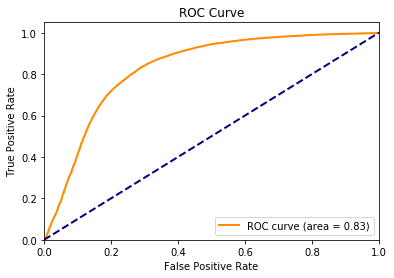

Iter 24900, Minibatch Loss= 0.401504, Training Accuracy= 0.86667
Iter 25050, Minibatch Loss= 0.556634, Training Accuracy= 0.73333
Iter 25200, Minibatch Loss= 0.503027, Training Accuracy= 0.80000
Iter 25350, Minibatch Loss= 0.421902, Training Accuracy= 0.93333
Iter 25500, Minibatch Loss= 0.380774, Training Accuracy= 0.93333
Validation Accuracy: 0.769
Validation Loss: 0.512166
Iter 25650, Minibatch Loss= 0.637123, Training Accuracy= 0.66667
Iter 25800, Minibatch Loss= 0.517460, Training Accuracy= 0.93333
Iter 25950, Minibatch Loss= 0.511549, Training Accuracy= 0.73333
Iter 26100, Minibatch Loss= 0.631081, Training Accuracy= 0.66667
Iter 26250, Minibatch Loss= 0.612986, Training Accuracy= 0.80000
Validation Accuracy: 0.76706
Validation Loss: 0.515319
Iter 26400, Minibatch Loss= 0.591435, Training Accuracy= 0.73333
Iter 26550, Minibatch Loss= 0.483766, Training Accuracy= 0.80000
Iter 26700, Minibatch Loss= 0.432186, Training Accuracy= 0.80000
Iter 26850, Minibatch Loss= 0.362003, Training 

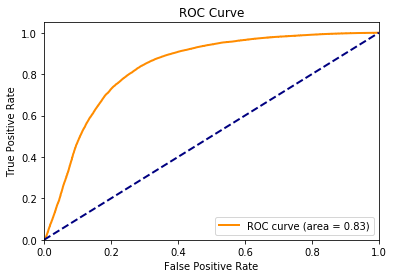

Iter 27900, Minibatch Loss= 0.590319, Training Accuracy= 0.73333
Iter 28050, Minibatch Loss= 0.490431, Training Accuracy= 0.73333
Iter 28200, Minibatch Loss= 0.500245, Training Accuracy= 0.73333
Iter 28350, Minibatch Loss= 0.304698, Training Accuracy= 0.86667
Iter 28500, Minibatch Loss= 0.531386, Training Accuracy= 0.80000
Validation Accuracy: 0.71032
Validation Loss: 0.600622
Iter 28650, Minibatch Loss= 0.792346, Training Accuracy= 0.53333
Iter 28800, Minibatch Loss= 0.375767, Training Accuracy= 0.80000
Iter 28950, Minibatch Loss= 0.486522, Training Accuracy= 0.73333
Iter 29100, Minibatch Loss= 0.359623, Training Accuracy= 0.86667
Iter 29250, Minibatch Loss= 0.543688, Training Accuracy= 0.86667
Validation Accuracy: 0.76724
Validation Loss: 0.50771
Iter 29400, Minibatch Loss= 0.373475, Training Accuracy= 0.86667
Iter 29550, Minibatch Loss= 0.583973, Training Accuracy= 0.66667
Iter 29700, Minibatch Loss= 0.482193, Training Accuracy= 0.80000
Iter 29850, Minibatch Loss= 0.411802, Training

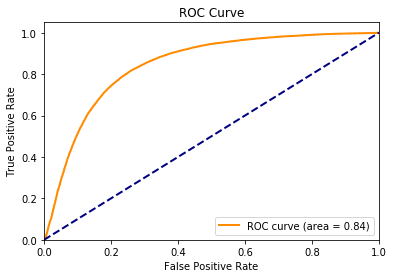

Iter 30150, Minibatch Loss= 0.627164, Training Accuracy= 0.66667
Iter 30300, Minibatch Loss= 0.816264, Training Accuracy= 0.40000
Iter 30450, Minibatch Loss= 0.533989, Training Accuracy= 0.86667
Iter 30600, Minibatch Loss= 0.404975, Training Accuracy= 0.86667
Iter 30750, Minibatch Loss= 0.375814, Training Accuracy= 0.86667
Validation Accuracy: 0.74538
Validation Loss: 0.530516
Iter 30900, Minibatch Loss= 0.599490, Training Accuracy= 0.60000
Iter 31050, Minibatch Loss= 0.335249, Training Accuracy= 0.93333
Iter 31200, Minibatch Loss= 0.519399, Training Accuracy= 0.73333
Iter 31350, Minibatch Loss= 0.524092, Training Accuracy= 0.73333
Iter 31500, Minibatch Loss= 0.342119, Training Accuracy= 0.86667
Validation Accuracy: 0.7704
Validation Loss: 0.508062
Iter 31650, Minibatch Loss= 0.575307, Training Accuracy= 0.66667
Iter 31800, Minibatch Loss= 0.608268, Training Accuracy= 0.60000
Iter 31950, Minibatch Loss= 0.483843, Training Accuracy= 0.80000
Iter 32100, Minibatch Loss= 0.443102, Training

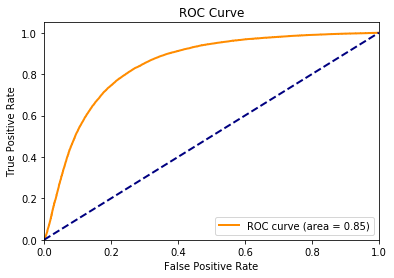

Iter 32400, Minibatch Loss= 0.665283, Training Accuracy= 0.60000
Iter 32550, Minibatch Loss= 0.379874, Training Accuracy= 0.86667
Iter 32700, Minibatch Loss= 0.632979, Training Accuracy= 0.60000
Iter 32850, Minibatch Loss= 0.479615, Training Accuracy= 0.80000
Iter 33000, Minibatch Loss= 0.396050, Training Accuracy= 0.86667
Validation Accuracy: 0.77716
Validation Loss: 0.493102
Iter 33150, Minibatch Loss= 0.707098, Training Accuracy= 0.60000
Iter 33300, Minibatch Loss= 0.381879, Training Accuracy= 0.80000
Iter 33450, Minibatch Loss= 0.425232, Training Accuracy= 0.86667
Iter 33600, Minibatch Loss= 0.610646, Training Accuracy= 0.66667
Iter 33750, Minibatch Loss= 0.498373, Training Accuracy= 0.80000
Validation Accuracy: 0.78136
Validation Loss: 0.493808


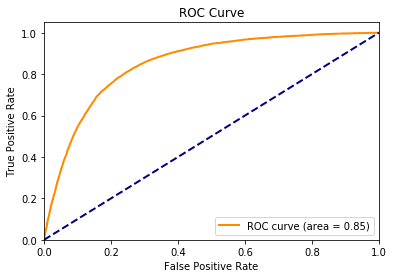

Iter 33900, Minibatch Loss= 0.448397, Training Accuracy= 0.80000
Iter 34050, Minibatch Loss= 0.317064, Training Accuracy= 0.86667
Iter 34200, Minibatch Loss= 0.316217, Training Accuracy= 0.86667
Iter 34350, Minibatch Loss= 0.341469, Training Accuracy= 0.80000
Iter 34500, Minibatch Loss= 0.476307, Training Accuracy= 0.73333
Validation Accuracy: 0.77318
Validation Loss: 0.496391
Iter 34650, Minibatch Loss= 0.439930, Training Accuracy= 0.80000
Iter 34800, Minibatch Loss= 0.627389, Training Accuracy= 0.80000
Iter 34950, Minibatch Loss= 0.372606, Training Accuracy= 0.80000
Iter 35100, Minibatch Loss= 0.604523, Training Accuracy= 0.73333
Iter 35250, Minibatch Loss= 0.417439, Training Accuracy= 0.86667
Validation Accuracy: 0.77042
Validation Loss: 0.500373
Iter 35400, Minibatch Loss= 0.477705, Training Accuracy= 0.66667
Iter 35550, Minibatch Loss= 0.840818, Training Accuracy= 0.53333
Iter 35700, Minibatch Loss= 0.690009, Training Accuracy= 0.66667
Iter 35850, Minibatch Loss= 0.603908, Trainin

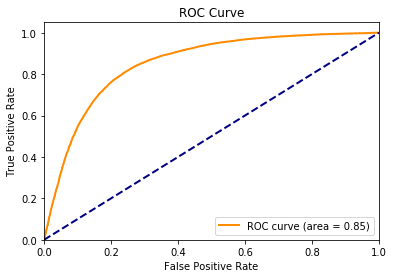

Iter 47400, Minibatch Loss= 0.325762, Training Accuracy= 0.93333
Iter 47550, Minibatch Loss= 0.615396, Training Accuracy= 0.73333
Iter 47700, Minibatch Loss= 0.660593, Training Accuracy= 0.60000
Iter 47850, Minibatch Loss= 0.313443, Training Accuracy= 0.86667
Iter 48000, Minibatch Loss= 0.570653, Training Accuracy= 0.73333
Validation Accuracy: 0.76766
Validation Loss: 0.508237
Iter 48150, Minibatch Loss= 0.543996, Training Accuracy= 0.73333
Iter 48300, Minibatch Loss= 0.441788, Training Accuracy= 0.93333
Iter 48450, Minibatch Loss= 0.313857, Training Accuracy= 0.93333
Iter 48600, Minibatch Loss= 0.533346, Training Accuracy= 0.73333
Iter 48750, Minibatch Loss= 0.288638, Training Accuracy= 0.86667
Validation Accuracy: 0.77052
Validation Loss: 0.493807
Iter 48900, Minibatch Loss= 0.432660, Training Accuracy= 0.66667
Iter 49050, Minibatch Loss= 0.184481, Training Accuracy= 1.00000
Iter 49200, Minibatch Loss= 0.390324, Training Accuracy= 0.86667
Iter 49350, Minibatch Loss= 0.549364, Trainin

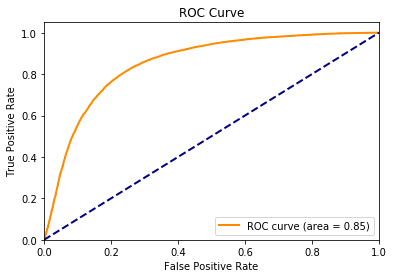

Iter 63900, Minibatch Loss= 0.661976, Training Accuracy= 0.53333
Iter 64050, Minibatch Loss= 0.697271, Training Accuracy= 0.60000
Iter 64200, Minibatch Loss= 0.687172, Training Accuracy= 0.66667
Iter 64350, Minibatch Loss= 0.377902, Training Accuracy= 0.86667
Iter 64500, Minibatch Loss= 0.514177, Training Accuracy= 0.73333
Validation Accuracy: 0.7616
Validation Loss: 0.512091
Iter 64650, Minibatch Loss= 0.364806, Training Accuracy= 0.86667
Iter 64800, Minibatch Loss= 0.582852, Training Accuracy= 0.60000
Iter 64950, Minibatch Loss= 0.470819, Training Accuracy= 0.80000
Iter 65100, Minibatch Loss= 0.542808, Training Accuracy= 0.73333
Iter 65250, Minibatch Loss= 0.560386, Training Accuracy= 0.73333
Validation Accuracy: 0.75692
Validation Loss: 0.513119
Iter 65400, Minibatch Loss= 0.489342, Training Accuracy= 0.73333
Iter 65550, Minibatch Loss= 0.661665, Training Accuracy= 0.73333
Iter 65700, Minibatch Loss= 0.522415, Training Accuracy= 0.80000
Iter 65850, Minibatch Loss= 0.539634, Training

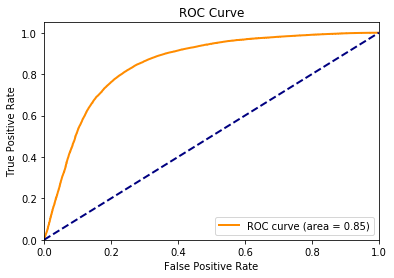

Iter 79650, Minibatch Loss= 0.790317, Training Accuracy= 0.53333
Iter 79800, Minibatch Loss= 0.425627, Training Accuracy= 0.80000
Iter 79950, Minibatch Loss= 0.394844, Training Accuracy= 0.86667
Iter 80100, Minibatch Loss= 0.839909, Training Accuracy= 0.60000
Iter 80250, Minibatch Loss= 0.573327, Training Accuracy= 0.66667
Validation Accuracy: 0.72382
Validation Loss: 0.536627
Iter 80400, Minibatch Loss= 0.512674, Training Accuracy= 0.73333
Iter 80550, Minibatch Loss= 0.668119, Training Accuracy= 0.73333
Iter 80700, Minibatch Loss= 0.364538, Training Accuracy= 0.93333
Iter 80850, Minibatch Loss= 0.552781, Training Accuracy= 0.66667
Iter 81000, Minibatch Loss= 0.376390, Training Accuracy= 0.86667
Validation Accuracy: 0.7811
Validation Loss: 0.484538
Iter 81150, Minibatch Loss= 0.509526, Training Accuracy= 0.73333
Iter 81300, Minibatch Loss= 0.513350, Training Accuracy= 0.66667
Iter 81450, Minibatch Loss= 0.595617, Training Accuracy= 0.60000
Iter 81600, Minibatch Loss= 0.631942, Training

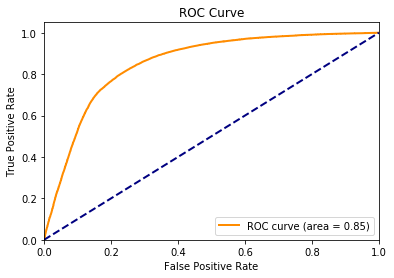

Iter 135900, Minibatch Loss= 0.379981, Training Accuracy= 0.80000
Iter 136050, Minibatch Loss= 0.334321, Training Accuracy= 0.86667
Iter 136200, Minibatch Loss= 0.398212, Training Accuracy= 0.93333
Iter 136350, Minibatch Loss= 0.693700, Training Accuracy= 0.66667
Iter 136500, Minibatch Loss= 0.518872, Training Accuracy= 0.80000
Validation Accuracy: 0.78644
Validation Loss: 0.474837


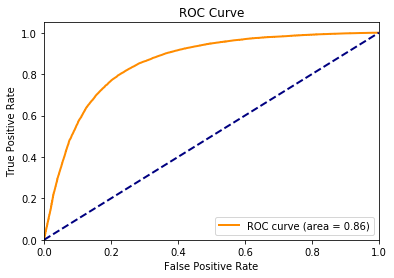

Iter 136650, Minibatch Loss= 0.429872, Training Accuracy= 0.80000
Iter 136800, Minibatch Loss= 0.455652, Training Accuracy= 0.73333
Iter 136950, Minibatch Loss= 0.396154, Training Accuracy= 0.80000
Iter 137100, Minibatch Loss= 0.400451, Training Accuracy= 0.86667
Iter 137250, Minibatch Loss= 0.446728, Training Accuracy= 0.80000
Validation Accuracy: 0.78332
Validation Loss: 0.479521
Iter 137400, Minibatch Loss= 0.637297, Training Accuracy= 0.66667
Iter 137550, Minibatch Loss= 0.450500, Training Accuracy= 0.80000
Iter 137700, Minibatch Loss= 0.432840, Training Accuracy= 0.73333
Iter 137850, Minibatch Loss= 0.662327, Training Accuracy= 0.66667
Iter 138000, Minibatch Loss= 0.403544, Training Accuracy= 0.80000
Validation Accuracy: 0.76394
Validation Loss: 0.502951
Iter 138150, Minibatch Loss= 0.501565, Training Accuracy= 0.66667
Iter 138300, Minibatch Loss= 0.456118, Training Accuracy= 0.80000
Iter 138450, Minibatch Loss= 0.572916, Training Accuracy= 0.66667
Iter 138600, Minibatch Loss= 0.6

In [12]:
%%time

best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))